In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import h5py
import torch
import random
import numpy as np
import pandas as pd
import torchmetrics
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

In [4]:
TRAIN_IMAGES_PATH = 'train.h5'
VAL_IMAGES_PATH = 'val.h5'
TEST_IMAGES_PATH = 'test.h5'
SEED = 0

In [5]:
torch.random.manual_seed(SEED)
random.seed(SEED)

In [6]:
from DLMI_histopathology.dataset import BaselineDataset, PrecomputedDataset,precompute

In [7]:
# Statistics on train set

mean = [0.7439, 0.5892, 0.7210] 
std = [0.1717, 0.2065, 0.1664]

# Create the normalization transform
transform = transforms.Compose([
            transforms.Resize((98, 98)),
            transforms.Normalize(mean=mean, std=std)
        ])



In [8]:
train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, transform, 'train')
val_dataset = BaselineDataset(VAL_IMAGES_PATH, transform, 'train')

In [9]:
from DLMI_histopathology.train import train_model

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on {device}.')

Working on cuda.


In [11]:
feature_extractor = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
feature_extractor.eval()

Using cache found in /raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main
/raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/raid/home/detectionfeuxdeforet/caillaud_gab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [12]:
BATCH_SIZE=64

In [19]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [20]:
train_dataset = PrecomputedDataset(*precompute(train_dataloader, feature_extractor, device))
val_dataset = PrecomputedDataset(*precompute(val_dataloader, feature_extractor, device))

  0%|          | 0/1563 [00:00<?, ?it/s]

/raid/home/detectionfeuxdeforet/caillaud_gab/dlmi/DLMI_histopathology/dataset.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  img = torch.tensor(hdf.get(img_id).get('img'))


  0%|          | 0/546 [00:00<?, ?it/s]

In [22]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [13]:
from DLMI_histopathology.models import HistoClassifierHead

In [14]:
model = HistoClassifierHead(dim_input=384, hidden_dim=64, dropout=0.2)
model.to(device)

HistoClassifierHead(
  (layer1): Linear(in_features=384, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=1, bias=True)
  (layernorm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [24]:
OPTIMIZER = 'AdamW'
OPTIMIZER_PARAMS = {'lr': 5e-4, 'weight_decay' : 0.02}
LOSS = 'BCELoss'
METRIC = 'Accuracy'
NUM_EPOCHS = 100
PATIENCE = 15
optimizer = getattr(torch.optim, OPTIMIZER)(model.parameters(), **OPTIMIZER_PARAMS)
criterion = getattr(torch.nn, LOSS)()
metric = getattr(torchmetrics, METRIC)('binary')
min_loss, best_epoch = float('inf'), 0

In [25]:
train_model(model, train_dataloader, val_dataloader, device, optimizer_name=OPTIMIZER, optimizer_params=OPTIMIZER_PARAMS, 
                 loss_name=LOSS, metric_name=METRIC, num_epochs=NUM_EPOCHS, patience=PATIENCE, save_path='best_model.pth')

Epoch [1/100] Train Loss: 0.1673 | Train Metric 0.9357 Val Loss: 0.4108 Val Metric 0.8546
New best loss inf -> 0.4108


Epoch [2/100] Train Loss: 0.1290 | Train Metric 0.9508 Val Loss: 0.3651 Val Metric 0.8651
New best loss 0.4108 -> 0.3651


Epoch [3/100] Train Loss: 0.1175 | Train Metric 0.9560 Val Loss: 0.4765 Val Metric 0.8506


Epoch [4/100] Train Loss: 0.1095 | Train Metric 0.9584 Val Loss: 0.4357 Val Metric 0.8637


Epoch [5/100] Train Loss: 0.1056 | Train Metric 0.9609 Val Loss: 0.5688 Val Metric 0.8313


Epoch [6/100] Train Loss: 0.1021 | Train Metric 0.9622 Val Loss: 0.4306 Val Metric 0.8572


Epoch [7/100] Train Loss: 0.0986 | Train Metric 0.9629 Val Loss: 0.4654 Val Metric 0.8588


Epoch [8/100] Train Loss: 0.0944 | Train Metric 0.9645 Val Loss: 0.4737 Val Metric 0.8566


Epoch [9/100] Train Loss: 0.0936 | Train Metric 0.9645 Val Loss: 0.4203 Val Metric 0.8650


Epoch [10/100] Train Loss: 0.0904 | Train Metric 0.9664 Val Loss: 0.4689 Val Metric 0.8611


Epoch [11/100] Train Loss: 0.0898 | Train Metric 0.9674 Val Loss: 0.4747 Val Metric 0.8556


Epoch [12/100] Train Loss: 0.0873 | Train Metric 0.9674 Val Loss: 0.5241 Val Metric 0.8455


Epoch [13/100] Train Loss: 0.0852 | Train Metric 0.9676 Val Loss: 0.5305 Val Metric 0.8582


Epoch [14/100] Train Loss: 0.0832 | Train Metric 0.9691 Val Loss: 0.4406 Val Metric 0.8631


Epoch [15/100] Train Loss: 0.0837 | Train Metric 0.9691 Val Loss: 0.4749 Val Metric 0.8567


Epoch [16/100] Train Loss: 0.0811 | Train Metric 0.9692 Val Loss: 0.3965 Val Metric 0.8715


Epoch [17/100] Train Loss: 0.0807 | Train Metric 0.9700 Val Loss: 0.4994 Val Metric 0.8609
Model has not improved in val set for 15 epochs. Stopping early.


In [37]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
model.to(device)
prediction_dict = {}

In [38]:
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    test_ids = list(hdf.keys())

In [39]:
solutions_data = {'ID': [], 'Pred': []}
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    for test_id in tqdm(test_ids):
        img = np.array(hdf.get(test_id).get('img'))
        img = transform(torch.tensor(img)).unsqueeze(0).float()
        pred = model(feature_extractor(img.to(device))).detach().cpu()
        solutions_data['ID'].append(int(test_id))
        solutions_data['Pred'].append(int(pred.item() > 0.5))
solutions_data = pd.DataFrame(solutions_data).set_index('ID')
solutions_data.to_csv('baseline.csv')

  0%|          | 0/85054 [00:00<?, ?it/s]

## test en prenant le modèle qui performe le mieux sur la val metric plutôt que sur la val loss

In [36]:
model = HistoClassifierHead(dim_input=384, hidden_dim=64, dropout=0.2)
model.to(device)
save_path  ="best_model.pth"
optimizer = getattr(torch.optim, "AdamW")(model.parameters(), **OPTIMIZER_PARAMS)
criterion = getattr(torch.nn, "BCELoss")()
metric = getattr(torchmetrics, METRIC)('binary')
num_epochs=NUM_EPOCHS
patience=PATIENCE
best_metric, best_epoch = 0, 0
model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_metrics, train_losses = [], []
    
    for train_x, train_y in tqdm(train_dataloader, leave=False):
        optimizer.zero_grad()
        train_pred = model(train_x.to(device))
        loss = criterion(train_pred, train_y.to(device))
        loss.backward()
        optimizer.step()
        
        train_losses.extend([loss.item()] * len(train_y))
        train_metric = metric(train_pred.cpu(), train_y.int().cpu())
        train_metrics.extend([train_metric.item()] * len(train_y))
    
    model.eval()
    val_metrics, val_losses = [], []
    
    for val_x, val_y in tqdm(val_dataloader, leave=False):
        with torch.no_grad():
            val_pred = model(val_x.to(device))
        loss = criterion(val_pred, val_y.to(device))
        
        val_losses.extend([loss.item()] * len(val_y))
        val_metric = metric(val_pred.cpu(), val_y.int().cpu())
        val_metrics.extend([val_metric.item()] * len(val_y))
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {np.mean(train_losses):.4f} | Train Metric {np.mean(train_metrics):.4f} '
            f'Val Loss: {np.mean(val_losses):.4f} Val Metric {np.mean(val_metrics):.4f}')
    
    if np.mean(val_metrics)> best_metric:
        mean_val_metric = np.mean(val_metrics)
        print(f'New best metric  {best_metric:.4f} -> {mean_val_metric:.4f}')
        best_metric = mean_val_metric
        best_epoch = epoch
        torch.save(model.state_dict(), save_path)
    
    if epoch - best_epoch == patience:
        print(f"Model has not improved in val set for {patience} epochs. Stopping early.")
        break

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [1/100] Train Loss: 0.1688 | Train Metric 0.9359 Val Loss: 0.4279 Val Metric 0.8600
New best metric  0.0000 -> 0.8600


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [2/100] Train Loss: 0.1285 | Train Metric 0.9511 Val Loss: 0.3418 Val Metric 0.8704
New best metric  0.8600 -> 0.8704


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [3/100] Train Loss: 0.1169 | Train Metric 0.9560 Val Loss: 0.4241 Val Metric 0.8601


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [4/100] Train Loss: 0.1109 | Train Metric 0.9574 Val Loss: 0.4052 Val Metric 0.8605


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [5/100] Train Loss: 0.1049 | Train Metric 0.9605 Val Loss: 0.3972 Val Metric 0.8684


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [6/100] Train Loss: 0.1012 | Train Metric 0.9621 Val Loss: 0.3795 Val Metric 0.8634


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [7/100] Train Loss: 0.0975 | Train Metric 0.9637 Val Loss: 0.4664 Val Metric 0.8503


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [8/100] Train Loss: 0.0946 | Train Metric 0.9651 Val Loss: 0.3969 Val Metric 0.8708
New best metric  0.8704 -> 0.8708


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [9/100] Train Loss: 0.0928 | Train Metric 0.9656 Val Loss: 0.4103 Val Metric 0.8594


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [10/100] Train Loss: 0.0905 | Train Metric 0.9661 Val Loss: 0.4423 Val Metric 0.8546


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [11/100] Train Loss: 0.0884 | Train Metric 0.9670 Val Loss: 0.5120 Val Metric 0.8493


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [12/100] Train Loss: 0.0878 | Train Metric 0.9670 Val Loss: 0.4756 Val Metric 0.8589


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [13/100] Train Loss: 0.0853 | Train Metric 0.9684 Val Loss: 0.4146 Val Metric 0.8718
New best metric  0.8708 -> 0.8718


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [14/100] Train Loss: 0.0840 | Train Metric 0.9685 Val Loss: 0.4014 Val Metric 0.8725
New best metric  0.8718 -> 0.8725


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [15/100] Train Loss: 0.0832 | Train Metric 0.9693 Val Loss: 0.4156 Val Metric 0.8658


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [16/100] Train Loss: 0.0815 | Train Metric 0.9698 Val Loss: 0.4666 Val Metric 0.8607


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [17/100] Train Loss: 0.0803 | Train Metric 0.9696 Val Loss: 0.5091 Val Metric 0.8549


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [18/100] Train Loss: 0.0801 | Train Metric 0.9698 Val Loss: 0.5025 Val Metric 0.8481


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [19/100] Train Loss: 0.0785 | Train Metric 0.9707 Val Loss: 0.3924 Val Metric 0.8741
New best metric  0.8725 -> 0.8741


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [20/100] Train Loss: 0.0783 | Train Metric 0.9710 Val Loss: 0.4626 Val Metric 0.8607


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [21/100] Train Loss: 0.0782 | Train Metric 0.9712 Val Loss: 0.4839 Val Metric 0.8620


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [22/100] Train Loss: 0.0754 | Train Metric 0.9723 Val Loss: 0.4784 Val Metric 0.8640


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [23/100] Train Loss: 0.0750 | Train Metric 0.9723 Val Loss: 0.4506 Val Metric 0.8646


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [24/100] Train Loss: 0.0740 | Train Metric 0.9729 Val Loss: 0.4732 Val Metric 0.8627


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [25/100] Train Loss: 0.0751 | Train Metric 0.9727 Val Loss: 0.5042 Val Metric 0.8569


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [26/100] Train Loss: 0.0738 | Train Metric 0.9724 Val Loss: 0.4725 Val Metric 0.8545


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [27/100] Train Loss: 0.0734 | Train Metric 0.9728 Val Loss: 0.4598 Val Metric 0.8601


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [28/100] Train Loss: 0.0728 | Train Metric 0.9728 Val Loss: 0.4660 Val Metric 0.8583


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [29/100] Train Loss: 0.0724 | Train Metric 0.9732 Val Loss: 0.5032 Val Metric 0.8480


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [30/100] Train Loss: 0.0725 | Train Metric 0.9732 Val Loss: 0.4459 Val Metric 0.8618


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [31/100] Train Loss: 0.0720 | Train Metric 0.9735 Val Loss: 0.5014 Val Metric 0.8513


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [32/100] Train Loss: 0.0711 | Train Metric 0.9734 Val Loss: 0.4726 Val Metric 0.8548


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [33/100] Train Loss: 0.0707 | Train Metric 0.9740 Val Loss: 0.5210 Val Metric 0.8508


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/546 [00:00<?, ?it/s]

Epoch [34/100] Train Loss: 0.0703 | Train Metric 0.9744 Val Loss: 0.4656 Val Metric 0.8641
Model has not improved in val set for 15 epochs. Stopping early.


Testing Macenko's stain normalization

In [ ]:
import staintools
import cv2

# Load the target image (reference image)
target_image = cv2.imread("target_image.jpg")

# Load the image to be normalized
source_image = cv2.imread("source_image.jpg")

# Convert images to RGB (OpenCV loads in BGR)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)

# Instantiate a stain normalizer
normalizer = staintools.StainNormalizer(method='macenko')

# Fit normalizer to target (reference) image
normalizer.fit(target_image)

# Normalize the source imageé
normalized_image = normalizer.transform(source_image)

In [18]:
target_image = np.load("image_center_0_healthy.npy")   # (H, W, 3), dtype=np.uint8
target_image.shape

(3, 96, 96)

In [19]:
target_image = target_image.astype(np.float32)

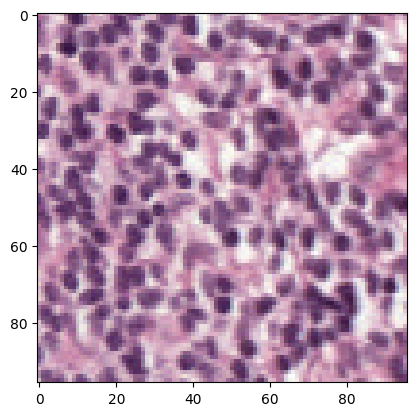

In [11]:
plt.imshow(target_image.swapaxes(0,2))

In [ ]:
source_image = train_dataset[0][0].numpy()

In [24]:
!pip install spams

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for spams (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [78 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build/lib.linux-x86_64-cpython-310/spams_wrap
      copying spams_wrap/__init__.py -> build/lib.linux-x86_64-cpython-310/spams_wrap
      copying spams_wrap/spams_wrap.py -> build/lib.linux-x86_64-cpython-310/spams_wrap
      creating build/lib.linux-x86_64-cpython-310/spams
      copying spams/spams.py -> build/lib.linux-x86_64-cpython-310/spams
      copying spams/__init__.py -> build/lib.linux-x86_64-cpython-310/spams
      creating build/lib.linux-x86_64-cpython-310/spams/tests
      copying spams/tests/test_spams.py -> build/lib.linux

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh

In [26]:
!pip install git+https://github.com/cwlkr/torchvahadane.git

  Cloning https://github.com/cwlkr/torchvahadane.git to /tmp/pip-req-build-ynnhiaf_
  Running command git clone --filter=blob:none --quiet https://github.com/cwlkr/torchvahadane.git /tmp/pip-req-build-ynnhiaf_
  Resolved https://github.com/cwlkr/torchvahadane.git to commit ec4c89b82e2b52aef093c34a730b99d3fa26d5e8
  Preparing metadata (setup.py) ... done
  Created wheel for torchvahadane: filename=torchvahadane-0.1.1-py3-none-any.whl size=18637 sha256=acd75613fbf044b1987fba39d0c723794d0e0ef3e973ea3d657ef6c77f12b1bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-_026k76b/wheels/a6/3f/83/3cdfcc3a0b36b24a8516cd9256f3eebb914d409b2f8d2c5d6d
Successfully built torchvahadane


In [27]:
from torchvahadane import TorchVahadaneNormalizer
normalizer = TorchVahadaneNormalizer(device='cuda', staintools_estimate=True)
normalizer.fit(target_image)
img_normed = normalizer.transform(source_image)

ModuleNotFoundError: No module named 'spams'

In [28]:
!pip install torchstain

In [84]:
import torch
from torchvision import transforms
import torchstain
import cv2


In [85]:
target_image.shape

(3, 96, 96)

In [86]:
T(torch.tensor(target_image)).shape

torch.Size([3, 98, 98])

In [133]:
T = transforms.Compose([
    transforms.Resize((98, 98)),
    transforms.Lambda(lambda x: x * 255),
    transforms.Lambda(lambda x: x.to(dtype=torch.uint8))
])

normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
normalizer.fit(T(torch.tensor(target_image)))

t_to_transform = T(torch.tensor(source_image))
norm, H, E = normalizer.normalize(I=t_to_transform, stains=True)

/tmp/ipykernel_409626/2273665722.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_to_transform = T(torch.tensor(source_image))


In [134]:
norm.shape

torch.Size([98, 98, 3])

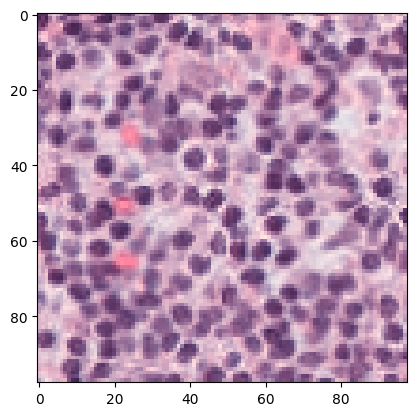

In [135]:
plt.imshow(norm.numpy())

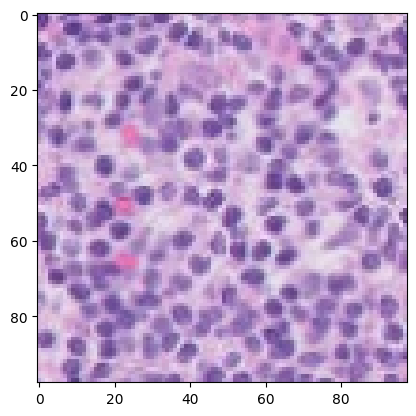

In [136]:
plt.imshow(source_image.permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.15625..1.953125].


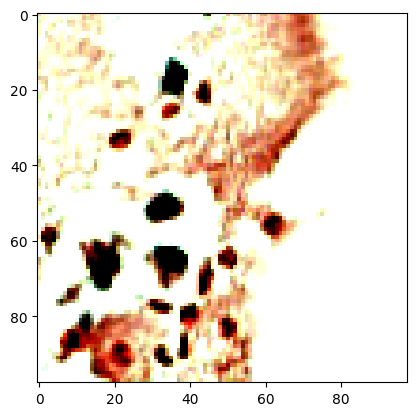

In [96]:
source_image = train_dataset[0][0]
source_image
plt.imshow(source_image.permute(1,2,0).numpy())

In [97]:
transform = transforms.Resize((98, 98))
train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, transform, 'train')
val_dataset = BaselineDataset(VAL_IMAGES_PATH, transform, 'train')

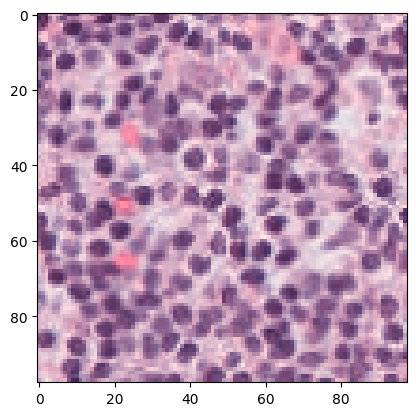

In [ ]:
source_image  =train_dataset[5][0]
DZZZ

In [141]:
target_image.shape

(3, 96, 96)

In [15]:
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np
from torchvision import transforms
from PIL import Image

class BaselineDataset(Dataset):
    def __init__(self, dataset_path, preprocessing, mode, target_image):
        super(BaselineDataset, self).__init__()
        self.dataset_path = dataset_path
        self.preprocessing = preprocessing
        self.mode = mode

        # Only used for fitting the normalizer
        self.resize = transforms.Resize((98, 98))
        self.to_uint8 = transforms.Lambda(lambda x: (x * 255).to(torch.uint8))

        # Fit Macenko normalizer
        self.normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        with torch.no_grad():
            ref_tensor = torch.tensor(target_image)
            if ref_tensor.ndim == 3 and ref_tensor.shape[0] != 3:
                ref_tensor = ref_tensor.permute(2, 0, 1)  # [C, H, W]

            ref_tensor = self.resize(ref_tensor)
            ref_tensor = self.to_uint8(ref_tensor)
            self.normalizer.fit(ref_tensor)

        with h5py.File(self.dataset_path, 'r') as hdf:        
            self.image_ids = list(hdf.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        with h5py.File(self.dataset_path, 'r') as hdf:
            img = torch.tensor(hdf.get(img_id).get('img'))  # assume [H, W, C]
            label = np.array(hdf.get(img_id).get('label')) if self.mode == 'train' else torch.tensor(-1)

        # Ensure [C, H, W]
        if img.ndim == 3 and img.shape[0] != 3:
            img = img.permute(2, 0, 1)

        # Resize
        img_resized = self.resize(img)

        # Convert to uint8 for normalization
        img_uint8 = self.to_uint8(img_resized)

        # Apply stain normalization (returns float32 in [0, 1])
        try:
            with torch.no_grad():
                norm_img,_,_ = self.normalizer.normalize(I=img_uint8, stains=False)
        except:
            print("error raised")
            return img_resized.to(torch.float32), label

        # Apply further preprocessing (e.g., Normalize for DINO)
        img_final = self.preprocessing(norm_img)

        return img_final.permute(2,0,1), label


preprocessing = transforms.Compose(
[
    transforms.Lambda(lambda x: x.to(dtype=torch.float32)),
    transforms.Lambda(lambda x: x / 255.0 ),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # If using DINOv2, might be ImageNet stats: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
])


In [187]:
train_dataset = BaselineDataset(TRAIN_IMAGES_PATH, preprocessing, mode="train", target_image=target_image)
val_dataset =  BaselineDataset(VAL_IMAGES_PATH, preprocessing, mode="train", target_image=target_image)

In [188]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1)

In [189]:
train_dataset = PrecomputedDataset(*precompute(train_dataloader, feature_extractor, device))
val_dataset = PrecomputedDataset(*precompute(val_dataloader, feature_extractor, device))

  0%|          | 0/100000 [00:00<?, ?it/s]

error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised
error raised


  0%|          | 0/34904 [00:00<?, ?it/s]

error raised


In [196]:
BATCH_SIZE=64
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [27]:
model = HistoClassifierHead(dim_input=768, hidden_dim=256, dropout=0.2)
model.to(device)

HistoClassifierHead(
  (layer1): Linear(in_features=768, out_features=256, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
  (layernorm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [204]:
OPTIMIZER = 'AdamW'
OPTIMIZER_PARAMS = {'lr': 5e-4, 'weight_decay' : 0.02}
LOSS = 'BCELoss'
METRIC = 'Accuracy'
NUM_EPOCHS = 100
PATIENCE = 15
optimizer = getattr(torch.optim, OPTIMIZER)(model.parameters(), **OPTIMIZER_PARAMS)
criterion = getattr(torch.nn, LOSS)()
metric = getattr(torchmetrics, METRIC)('binary')
min_loss, best_epoch = float('inf'), 0

In [205]:
from DLMI_histopathology.train import train_model

In [206]:
train_model(model, train_dataloader, val_dataloader, device, optimizer_name=OPTIMIZER, optimizer_params=OPTIMIZER_PARAMS, 
                 loss_name=LOSS, metric_name=METRIC, num_epochs=NUM_EPOCHS, patience=PATIENCE, save_path='best_model.pth')

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch [1/100] Train Loss: 0.1657 | Train Metric 0.9356 Val Loss: 0.4847 Val Metric 0.8255
New best loss inf -> 0.4847


Epoch [2/100] Train Loss: 0.1289 | Train Metric 0.9501 Val Loss: 0.4876 Val Metric 0.8463


Epoch [3/100] Train Loss: 0.1178 | Train Metric 0.9550 Val Loss: 0.5111 Val Metric 0.8501


Epoch [4/100] Train Loss: 0.1103 | Train Metric 0.9582 Val Loss: 0.4565 Val Metric 0.8633
New best loss 0.4847 -> 0.4565


Epoch [5/100] Train Loss: 0.1046 | Train Metric 0.9604 Val Loss: 0.4919 Val Metric 0.8501


Epoch [6/100] Train Loss: 0.0980 | Train Metric 0.9631 Val Loss: 0.4517 Val Metric 0.8627
New best loss 0.4565 -> 0.4517


Epoch [7/100] Train Loss: 0.0936 | Train Metric 0.9640 Val Loss: 0.4872 Val Metric 0.8457


Epoch [8/100] Train Loss: 0.0895 | Train Metric 0.9657 Val Loss: 0.4757 Val Metric 0.8509


Epoch [9/100] Train Loss: 0.0860 | Train Metric 0.9675 Val Loss: 0.5538 Val Metric 0.8429


Epoch [10/100] Train Loss: 0.0830 | Train Metric 0.9686 Val Loss: 0.5239 Val Metric 0.8560


Epoch [11/100] Train Loss: 0.0792 | Train Metric 0.9701 Val Loss: 0.5001 Val Metric 0.8523


Epoch [12/100] Train Loss: 0.0779 | Train Metric 0.9703 Val Loss: 0.5697 Val Metric 0.8495


Epoch [13/100] Train Loss: 0.0740 | Train Metric 0.9719 Val Loss: 0.5590 Val Metric 0.8491


Epoch [14/100] Train Loss: 0.0713 | Train Metric 0.9733 Val Loss: 0.6422 Val Metric 0.8386


Epoch [15/100] Train Loss: 0.0680 | Train Metric 0.9744 Val Loss: 0.5243 Val Metric 0.8602


Epoch [16/100] Train Loss: 0.0673 | Train Metric 0.9749 Val Loss: 0.5731 Val Metric 0.8422


Epoch [17/100] Train Loss: 0.0658 | Train Metric 0.9752 Val Loss: 0.5801 Val Metric 0.8497


Epoch [18/100] Train Loss: 0.0641 | Train Metric 0.9760 Val Loss: 0.6498 Val Metric 0.8418


Epoch [19/100] Train Loss: 0.0609 | Train Metric 0.9770 Val Loss: 0.5906 Val Metric 0.8539


Epoch [20/100] Train Loss: 0.0602 | Train Metric 0.9775 Val Loss: 0.6837 Val Metric 0.8361


Epoch [21/100] Train Loss: 0.0582 | Train Metric 0.9780 Val Loss: 0.6933 Val Metric 0.8417
Model has not improved in val set for 15 epochs. Stopping early.


In [28]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
model.to(device)
prediction_dict = {}
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    test_ids = list(hdf.keys())

In [16]:
def precompute(dataloader, model, device, return_labels=True):
    xs, ys = [], []
    for batch in tqdm(dataloader, leave=False):
        if return_labels:
            x, y = batch
        else:
            x = batch[0]

        with torch.no_grad():
            feats = model(x.to(device)).detach().cpu().numpy()
            xs.append(feats)

        if return_labels:
            ys.append(y.numpy())

    xs = np.vstack(xs)
    if return_labels:
        ys = np.hstack(ys)
        return torch.tensor(xs), torch.tensor(ys)
    else:
        return torch.tensor(xs)

In [1]:
import torchstain

In [23]:
test_dataset =  BaselineDataset(TEST_IMAGES_PATH, preprocessing, mode="test", target_image=target_image)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)
test_dataset  =PrecomputedDataset(*precompute(test_dataloader, feature_extractor, device, return_labels=False))

  0%|          | 0/85054 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(test_dataset, "precomputed_test_features.pt")

PicklingError: Can't pickle <function <lambda> at 0x7f03dc231630>: attribute lookup <lambda> on __main__ failed

In [7]:
test_dataset = torch.load("precomputed_test_features.pt")

/tmp/ipykernel_928920/2514235086.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset = torch.load("precomputed_test_features.pt")


FileNotFoundError: [Errno 2] No such file or directory: 'precomputed_test_features.pt'

In [ ]:
solutions_data = {'ID': [], 'Pred': []}
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    for test_id in tqdm(test_ids):
        img = np.array(hdf.get(test_id).get('img'))
        img = preprocessing(torch.tensor(img)).unsqueeze(0).float()
        pred = model(feature_extractor(img.to(device))).detach().cpu()
        solutions_data['ID'].append(int(test_id))
        solutions_data['Pred'].append(int(pred.item() > 0.5))
solutions_data = pd.DataFrame(solutions_data).set_index('ID')
solutions_data.to_csv('baseline.csv')

In [25]:
resize = transforms.Resize((98, 98))
to_uint8 = transforms.Lambda(lambda x: (x * 255).to(torch.uint8))

# Fit Macenko normalizer
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
with torch.no_grad():
    ref_tensor = torch.tensor(target_image)
    if ref_tensor.ndim == 3 and ref_tensor.shape[0] != 3:
        ref_tensor = ref_tensor.permute(2, 0, 1)  # [C, H, W]

    ref_tensor = resize(ref_tensor)
    ref_tensor = to_uint8(ref_tensor)
    normalizer.fit(ref_tensor)

preprocessing = transforms.Compose(
[
    transforms.Lambda(lambda x: x.to(dtype=torch.float32)),
    transforms.Lambda(lambda x: x / 255.0 ),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # If using DINOv2, might be ImageNet stats: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
])


In [33]:
solutions_data = {'ID': [], 'Pred': []}
with h5py.File(TEST_IMAGES_PATH, 'r') as hdf:
    for test_id in tqdm(test_ids):
        img = torch.tensor(hdf.get(test_id).get('img'))  # assume [H, W, C]
        # Ensure [C, H, W]
        if img.ndim == 3 and img.shape[0] != 3:
            img = img.permute(2, 0, 1)
        img_resized = resize(img)
        # Convert to uint8 for normalization
        img_uint8 = to_uint8(img_resized)

        # Apply stain normalization (returns float32 in [0, 1])
        try:
            with torch.no_grad():
                norm_img,_,_ = normalizer.normalize(I=img_uint8, stains=False)
            # Apply further preprocessing (e.g., Normalize for DINO)
            img_final = preprocessing(norm_img)
            img_final = img_final.permute(2,0,1).unsqueeze(0)
        except:
            print("error raised")
            if img_resized.ndim == 3 and img_resized.shape[0] != 3:
                img_resized = img_resized.permute(2, 0, 1)
            norm_img= img_resized.to(torch.float32)
            img_final = preprocessing(norm_img).unsqueeze(0)

        pred = model(feature_extractor(img_final.to(device))).detach().cpu()
        solutions_data['ID'].append(int(test_id))
        solutions_data['Pred'].append(int(pred.item() > 0.5))
solutions_data = pd.DataFrame(solutions_data).set_index('ID')
solutions_data.to_csv('results5.csv')

  0%|          | 0/85054 [00:00<?, ?it/s]

error raised
error raised
